# Your First RAG Application

In this notebook, we'll walk you through each of the components that are involved in a simple RAG application.

We won't be leveraging any fancy tools, just the OpenAI Python SDK, Numpy, and some classic Python.

> NOTE: This was done with Python 3.11.4.

> NOTE: There might be [compatibility issues](https://github.com/wandb/wandb/issues/7683) if you're on NVIDIA driver >552.44 As an interim solution - you can rollback your drivers to the 552.44.

## Table of Contents:

- Task 1: Imports and Utilities
- Task 2: Documents
- Task 3: Embeddings and Vectors
- Task 4: Prompts
- Task 5: Retrieval Augmented Generation
  - 🚧 Activity #1: Augment RAG

Let's look at a rather complicated looking visual representation of a basic RAG application.

<img src="https://i.imgur.com/vD8b016.png" />

## Task 1: Imports and Utility

We're just doing some imports and enabling `async` to work within the Jupyter environment here, nothing too crazy!

In [1]:
!pip install -qU numpy matplotlib plotly pandas scipy scikit-learn openai python-dotenv

In [2]:
from aimakerspace.text_utils import TextFileLoader, CharacterTextSplitter
from aimakerspace.vectordatabase import VectorDatabase
import asyncio

In [3]:
import nest_asyncio
nest_asyncio.apply()

## Task 2: Documents

We'll be concerning ourselves with this part of the flow in the following section:

<img src="https://i.imgur.com/jTm9gjk.png" />

### Loading Source Documents

So, first things first, we need some documents to work with.

While we could work directly with the `.txt` files (or whatever file-types you wanted to extend this to) we can instead do some batch processing of those documents at the beginning in order to store them in a more machine compatible format.

In this case, we're going to parse our text file into a single document in memory.

Let's look at the relevant bits of the `TextFileLoader` class:

```python
def load_file(self):
        with open(self.path, "r", encoding=self.encoding) as f:
            self.documents.append(f.read())
```

We're simply loading the document using the built in `open` method, and storing that output in our `self.documents` list.


In [4]:
text_loader = TextFileLoader("data/PMarcaBlogs.txt")
documents = text_loader.load_documents()
len(documents)

1

In [5]:
print(documents[0][:100])


The Pmarca Blog Archives
(select posts from 2007-2009)
Marc Andreessen
copyright: Andreessen Horow


### Splitting Text Into Chunks

As we can see, there is one massive document.

We'll want to chunk the document into smaller parts so it's easier to pass the most relevant snippets to the LLM.

There is no fixed way to split/chunk documents - and you'll need to rely on some intuition as well as knowing your data *very* well in order to build the most robust system.

For this toy example, we'll just split blindly on length.

>There's an opportunity to clear up some terminology here, for this course we will be stick to the following:
>
>- "source documents" : The `.txt`, `.pdf`, `.html`, ..., files that make up the files and information we start with in its raw format
>- "document(s)" : single (or more) text object(s)
>- "corpus" : the combination of all of our documents

As you can imagine (though it's not specifically true in this toy example) the idea of splitting documents is to break them into managable sized chunks that retain the most relevant local context.

In [6]:
text_splitter = CharacterTextSplitter()
split_documents = text_splitter.split_texts(documents)
len(split_documents)

373

Let's take a look at some of the documents we've managed to split.

In [8]:
split_documents[0:1]

['\ufeff\nThe Pmarca Blog Archives\n(select posts from 2007-2009)\nMarc Andreessen\ncopyright: Andreessen Horowitz\ncover design: Jessica Hagy\nproduced using: Pressbooks\nContents\nTHE PMARCA GUIDE TO STARTUPS\nPart 1: Why not to do a startup 2\nPart 2: When the VCs say "no" 10\nPart 3: "But I don\'t know any VCs!" 18\nPart 4: The only thing that matters 25\nPart 5: The Moby Dick theory of big companies 33\nPart 6: How much funding is too little? Too much? 41\nPart 7: Why a startup\'s initial business plan doesn\'t\nmatter that much\n49\nTHE PMARCA GUIDE TO HIRING\nPart 8: Hiring, managing, promoting, and Dring\nexecutives\n54\nPart 9: How to hire a professional CEO 68\nHow to hire the best people you\'ve ever worked\nwith\n69\nTHE PMARCA GUIDE TO BIG COMPANIES\nPart 1: Turnaround! 82\nPart 2: Retaining great people 86\nTHE PMARCA GUIDE TO CAREER, PRODUCTIVITY,\nAND SOME OTHER THINGS\nIntroduction 97\nPart 1: Opportunity 99\nPart 2: Skills and education 107\nPart 3: Where to go and wh

## Task 3: Embeddings and Vectors

Next, we have to convert our corpus into a "machine readable" format as we explored in the Embedding Primer notebook.

Today, we're going to talk about the actual process of creating, and then storing, these embeddings, and how we can leverage that to intelligently add context to our queries.

### OpenAI API Key

In order to access OpenAI's APIs, we'll need to provide our OpenAI API Key!

You can work through the folder "OpenAI API Key Setup" for more information on this process if you don't already have an API Key!

In [7]:
import os
import openai
from getpass import getpass

openai.api_key = getpass("OpenAI API Key: ")
os.environ["OPENAI_API_KEY"] = openai.api_key

### Vector Database

Let's set up our vector database to hold all our documents and their embeddings!

While this is all baked into 1 call - we can look at some of the code that powers this process to get a better understanding:

Let's look at our `VectorDatabase().__init__()`:

```python
def __init__(self, embedding_model: EmbeddingModel = None):
        self.vectors = defaultdict(np.array)
        self.embedding_model = embedding_model or EmbeddingModel()
```

As you can see - our vectors are merely stored as a dictionary of `np.array` objects.

Secondly, our `VectorDatabase()` has a default `EmbeddingModel()` which is a wrapper for OpenAI's `text-embedding-3-small` model.

> **Quick Info About `text-embedding-3-small`**:
> - It has a context window of **8191** tokens
> - It returns vectors with dimension **1536**

#### ❓Question #1:

The default embedding dimension of `text-embedding-3-small` is 1536, as noted above. 

1. Is there any way to modify this dimension?
2. What technique does OpenAI use to achieve this?

> NOTE: Check out this [API documentation](https://platform.openai.com/docs/api-reference/embeddings/create) for the answer to question #1, and [this documentation](https://platform.openai.com/docs/guides/embeddings/use-cases) for an answer to question #2!

#### Answers 1
1. We can modify the dimensions of an embedding model by calling the Open AI embedding endpoint and providing our own value in the 'dimensions' parameter.
2. Open AI uses Matryoshka Representation learning to train their embedding models to allow developers to trade-off performance and cost of using embeddings. After using the api parameter "dimension" as mentioned above, you also need to normalize the values like below

response = client.embeddings.create(
    model="text-embedding-3-small", input="Testing 123", encoding_format="float"
)

cut_dim = response.data[0].embedding[:256]
norm_dim = normalize_l2(cut_dim)

We can call the `async_get_embeddings` method of our `EmbeddingModel()` on a list of `str` and receive a list of `float` back!

```python
async def async_get_embeddings(self, list_of_text: List[str]) -> List[List[float]]:
        return await aget_embeddings(
            list_of_text=list_of_text, engine=self.embeddings_model_name
        )
```

We cast those to `np.array` when we build our `VectorDatabase()`:

```python
async def abuild_from_list(self, list_of_text: List[str]) -> "VectorDatabase":
        embeddings = await self.embedding_model.async_get_embeddings(list_of_text)
        for text, embedding in zip(list_of_text, embeddings):
            self.insert(text, np.array(embedding))
        return self
```

And that's all we need to do!

In [9]:
vector_db = VectorDatabase()
vector_db = asyncio.run(vector_db.abuild_from_list(split_documents))

#### ❓Question #2:

What are the benefits of using an `async` approach to collecting our embeddings?

> NOTE: Determining the core difference between `async` and `sync` will be useful! If you get stuck - ask ChatGPT!

#### Answer 2 
As with most programming solutions, async processing allows multiple tasks to run concurrently to use reforces more effectively and in less time. This applies to collecting embeddings as well


So, to review what we've done so far in natural language:

1. We load source documents
2. We split those source documents into smaller chunks (documents)
3. We send each of those documents to the `text-embedding-3-small` OpenAI API endpoint
4. We store each of the text representations with the vector representations as keys/values in a dictionary

### Semantic Similarity

The next step is to be able to query our `VectorDatabase()` with a `str` and have it return to us vectors and text that is most relevant from our corpus.

We're going to use the following process to achieve this in our toy example:

1. We need to embed our query with the same `EmbeddingModel()` as we used to construct our `VectorDatabase()`
2. We loop through every vector in our `VectorDatabase()` and use a distance measure to compare how related they are
3. We return a list of the top `k` closest vectors, with their text representations

There's some very heavy optimization that can be done at each of these steps - but let's just focus on the basic pattern in this notebook.

> We are using [cosine similarity](https://www.engati.com/glossary/cosine-similarity) as a distance metric in this example - but there are many many distance metrics you could use - like [these](https://flavien-vidal.medium.com/similarity-distances-for-natural-language-processing-16f63cd5ba55)

> We are using a rather inefficient way of calculating relative distance between the query vector and all other vectors - there are more advanced approaches that are much more efficient, like [ANN](https://towardsdatascience.com/comprehensive-guide-to-approximate-nearest-neighbors-algorithms-8b94f057d6b6)

In [10]:
vector_db.search_by_text("What is the Michael Eisner Memorial Weak Executive Problem?", k=3)

[('ordingly.\nSeventh, when hiring the executive to run your former specialty, be\ncareful you don’t hire someone weak on purpose.\nThis sounds silly, but you wouldn’t believe how oaen it happens.\nThe CEO who used to be a product manager who has a weak\nproduct management executive. The CEO who used to be in\nsales who has a weak sales executive. The CEO who used to be\nin marketing who has a weak marketing executive.\nI call this the “Michael Eisner Memorial Weak Executive Problem” — aaer the CEO of Disney who had previously been a brilliant TV network executive. When he bought ABC at Disney, it\npromptly fell to fourth place. His response? “If I had an extra\ntwo days a week, I could turn around ABC myself.” Well, guess\nwhat, he didn’t have an extra two days a week.\nA CEO — or a startup founder — oaen has a hard time letting\ngo of the function that brought him to the party. The result: you\nhire someone weak into the executive role for that function so\nthat you can continue to b

## Task 4: Prompts

In the following section, we'll be looking at the role of prompts - and how they help us to guide our application in the right direction.

In this notebook, we're going to rely on the idea of "zero-shot in-context learning".

This is a lot of words to say: "We will ask it to perform our desired task in the prompt, and provide no examples."

### XYZRolePrompt

Before we do that, let's stop and think a bit about how OpenAI's chat models work.

We know they have roles - as is indicated in the following API [documentation](https://platform.openai.com/docs/api-reference/chat/create#chat/create-messages)

There are three roles, and they function as follows (taken directly from [OpenAI](https://platform.openai.com/docs/guides/gpt/chat-completions-api)):

- `{"role" : "system"}` : The system message helps set the behavior of the assistant. For example, you can modify the personality of the assistant or provide specific instructions about how it should behave throughout the conversation. However note that the system message is optional and the model’s behavior without a system message is likely to be similar to using a generic message such as "You are a helpful assistant."
- `{"role" : "user"}` : The user messages provide requests or comments for the assistant to respond to.
- `{"role" : "assistant"}` : Assistant messages store previous assistant responses, but can also be written by you to give examples of desired behavior.

The main idea is this:

1. You start with a system message that outlines how the LLM should respond, what kind of behaviours you can expect from it, and more
2. Then, you can provide a few examples in the form of "assistant"/"user" pairs
3. Then, you prompt the model with the true "user" message.

In this example, we'll be forgoing the 2nd step for simplicities sake.

#### Utility Functions

You'll notice that we're using some utility functions from the `aimakerspace` module - let's take a peek at these and see what they're doing!

##### XYZRolePrompt

Here we have our `system`, `user`, and `assistant` role prompts.

Let's take a peek at what they look like:

```python
class BasePrompt:
    def __init__(self, prompt):
        """
        Initializes the BasePrompt object with a prompt template.

        :param prompt: A string that can contain placeholders within curly braces
        """
        self.prompt = prompt
        self._pattern = re.compile(r"\{([^}]+)\}")

    def format_prompt(self, **kwargs):
        """
        Formats the prompt string using the keyword arguments provided.

        :param kwargs: The values to substitute into the prompt string
        :return: The formatted prompt string
        """
        matches = self._pattern.findall(self.prompt)
        return self.prompt.format(**{match: kwargs.get(match, "") for match in matches})

    def get_input_variables(self):
        """
        Gets the list of input variable names from the prompt string.

        :return: List of input variable names
        """
        return self._pattern.findall(self.prompt)
```

Then we have our `RolePrompt` which laser focuses us on the role pattern found in most API endpoints for LLMs.

```python
class RolePrompt(BasePrompt):
    def __init__(self, prompt, role: str):
        """
        Initializes the RolePrompt object with a prompt template and a role.

        :param prompt: A string that can contain placeholders within curly braces
        :param role: The role for the message ('system', 'user', or 'assistant')
        """
        super().__init__(prompt)
        self.role = role

    def create_message(self, **kwargs):
        """
        Creates a message dictionary with a role and a formatted message.

        :param kwargs: The values to substitute into the prompt string
        :return: Dictionary containing the role and the formatted message
        """
        return {"role": self.role, "content": self.format_prompt(**kwargs)}
```

We'll look at how the `SystemRolePrompt` is constructed to get a better idea of how that extension works:

```python
class SystemRolePrompt(RolePrompt):
    def __init__(self, prompt: str):
        super().__init__(prompt, "system")
```

That pattern is repeated for our `UserRolePrompt` and our `AssistantRolePrompt` as well.

##### ChatOpenAI

Next we have our model, which is converted to a format analagous to libraries like LangChain and LlamaIndex.

Let's take a peek at how that is constructed:

```python
class ChatOpenAI:
    def __init__(self, model_name: str = "gpt-4o-mini"):
        self.model_name = model_name
        self.openai_api_key = os.getenv("OPENAI_API_KEY")
        if self.openai_api_key is None:
            raise ValueError("OPENAI_API_KEY is not set")

    def run(self, messages, text_only: bool = True):
        if not isinstance(messages, list):
            raise ValueError("messages must be a list")

        openai.api_key = self.openai_api_key
        response = openai.ChatCompletion.create(
            model=self.model_name, messages=messages
        )

        if text_only:
            return response.choices[0].message.content

        return response
```

#### ❓ Question #3:

When calling the OpenAI API - are there any ways we can achieve more reproducible outputs?

> NOTE: Check out [this section](https://platform.openai.com/docs/guides/text-generation/) of the OpenAI documentation for the answer!

#### Answer 4

Set the temperature value for more reproducible outputs


### Creating and Prompting OpenAI's `gpt-4o-mini`!

Let's tie all these together and use it to prompt `gpt-4o-mini`!

In [11]:
from aimakerspace.openai_utils.prompts import (
    UserRolePrompt,
    SystemRolePrompt,
    AssistantRolePrompt,
)

from aimakerspace.openai_utils.chatmodel import ChatOpenAI

chat_openai = ChatOpenAI()
user_prompt_template = "{content}"
user_role_prompt = UserRolePrompt(user_prompt_template)
system_prompt_template = (
    "You are an expert in {expertise}, you always answer in a kind way."
)
system_role_prompt = SystemRolePrompt(system_prompt_template)

messages = [
    system_role_prompt.create_message(expertise="Python"),
    user_role_prompt.create_message(
        content="What is the best way to write a loop?"
    ),
]

response = chat_openai.run(messages)

In [12]:
print(response)

The best way to write a loop in Python largely depends on what you want to achieve, but here are some general tips and examples to help you write effective loops:

### 1. **Using a `for` Loop**
A `for` loop is great when you want to iterate over a sequence (like a list, tuple, string, or range).

**Example: Iterating through a list**
```python
fruits = ['apple', 'banana', 'cherry']
for fruit in fruits:
    print(fruit)
```

**Example: Using `range()`**
```python
for i in range(5):
    print(i)
```

### 2. **Using a `while` Loop**
A `while` loop is useful when you want to repeat an action until a condition changes.

**Example: Basic While Loop**
```python
count = 0
while count < 5:
    print(count)
    count += 1
```

### 3. **Using Break and Continue**
You can control the flow of your loops using `break` and `continue`.

**Example of `break`**
```python
for num in range(10):
    if num == 5:
        break  # Exit the loop
    print(num)
```

**Example of `continue`**
```python
for num 

## Task 5: Retrieval Augmented Generation

Now we can create a RAG prompt - which will help our system behave in a way that makes sense!

There is much you could do here, many tweaks and improvements to be made!

In [13]:
RAG_PROMPT_TEMPLATE = """ \
Use the provided context to answer the user's query.

You may not answer the user's query unless there is specific context in the following text.

If you do not know the answer, or cannot answer, please respond with "I don't know".
"""

rag_prompt = SystemRolePrompt(RAG_PROMPT_TEMPLATE)

USER_PROMPT_TEMPLATE = """ \
Context:
{context}

User Query:
{user_query}
"""


user_prompt = UserRolePrompt(USER_PROMPT_TEMPLATE)

class RetrievalAugmentedQAPipeline:
    def __init__(self, llm: ChatOpenAI(), vector_db_retriever: VectorDatabase) -> None:
        self.llm = llm
        self.vector_db_retriever = vector_db_retriever

    def run_pipeline(self, user_query: str) -> str:
        context_list = self.vector_db_retriever.search_by_text(user_query, k=4)

        context_prompt = ""
        for context in context_list:
            context_prompt += context[0] + "\n"

        formatted_system_prompt = rag_prompt.create_message()

        formatted_user_prompt = user_prompt.create_message(user_query=user_query, context=context_prompt)

        return {"response" : self.llm.run([formatted_system_prompt, formatted_user_prompt]), "context" : context_list}

#### ❓ Question #4:

What prompting strategies could you use to make the LLM have a more thoughtful, detailed response?

What is that strategy called?

> NOTE: You can look through the Week 1 Day 1 "Prompting OpenAI Like A Developer" material for an answer to this question!

#### Answer
There are a few other prompting strategies like Contextual Prompting to provide additional background info for a more detailed response i.e. "Given the recent advancements in AI technology, how do you think it will impact the job market in the next decade? Consider factors such as automation, job displacement, and new job creation."

In [14]:
retrieval_augmented_qa_pipeline = RetrievalAugmentedQAPipeline(
    vector_db_retriever=vector_db,
    llm=chat_openai
)

In [15]:
retrieval_augmented_qa_pipeline.run_pipeline("What is the 'Michael Eisner Memorial Weak Executive Problem'?")

{'response': "The 'Michael Eisner Memorial Weak Executive Problem' refers to the tendency of a CEO or startup founder to hire a weak executive in a critical function they previously excelled at, in order to maintain their own influence or control over that area. The context cites the example of Michael Eisner, the former CEO of Disney, who, despite being a brilliant TV network executive, faced challenges when he hired a weak leadership team for ABC after acquiring it. Eisner's inability to let go of the functions that defined his success led to poor performance in those areas. This phenomenon illustrates the importance of hiring strong executives rather than weak ones for critical roles to avoid undermining the organization's effectiveness.",
 'context': [('ordingly.\nSeventh, when hiring the executive to run your former specialty, be\ncareful you don’t hire someone weak on purpose.\nThis sounds silly, but you wouldn’t believe how oaen it happens.\nThe CEO who used to be a product mana

### 🏗️ Activity #1:

Enhance your RAG application in some way! 

Suggestions are: 

- Allow it to work with PDF files
- Implement a new distance metric
- Add metadata support to the vector database

While these are suggestions, you should feel free to make whatever augmentations you desire! 

> NOTE: These additions might require you to work within the `aimakerspace` library - that's expected!

In [20]:
from aimakerspace.vectormetadatadb import VectorMetaDatabase 
 
import numpy as np

# load file
text_loader = TextFileLoader("data/PMarcaBlogs.txt")
documents = text_loader.load_documents()
print(len(documents))

#init vector db
vector_db = VectorMetaDatabase()
vector_db = asyncio.run(vector_db.abuild_from_list(split_documents))

# Iterate throgh documents and insert with metadata (I used a small sample so their is 1 document)
for doc in documents:
    vector_db.insert(doc, np.random.rand(1536), {"title": "PMarcaBlogs.txt", "author": "Marc Andreessen"})



#  Perform a search and retrieve metadata
query_vector = np.random.rand(1536)
results = vector_db.search(query_vector, k=2)

# Display the results
for key, score, metadata in results:
    print(f"Key: {key}, Score: {score}, Metadata: {metadata}")

# Retrieve metadata for a specific key
metadata = vector_db.retrieve_metadata(doc)
print(f"Metadata for 'doc': {metadata}")

1
Key: ﻿
The Pmarca Blog Archives
(select posts from 2007-2009)
Marc Andreessen
copyright: Andreessen Horowitz
cover design: Jessica Hagy
produced using: Pressbooks
Contents
THE PMARCA GUIDE TO STARTUPS
Part 1: Why not to do a startup 2
Part 2: When the VCs say "no" 10
Part 3: "But I don't know any VCs!" 18
Part 4: The only thing that matters 25
Part 5: The Moby Dick theory of big companies 33
Part 6: How much funding is too little? Too much? 41
Part 7: Why a startup's initial business plan doesn't
matter that much
49
THE PMARCA GUIDE TO HIRING
Part 8: Hiring, managing, promoting, and Dring
executives
54
Part 9: How to hire a professional CEO 68
How to hire the best people you've ever worked
with
69
THE PMARCA GUIDE TO BIG COMPANIES
Part 1: Turnaround! 82
Part 2: Retaining great people 86
THE PMARCA GUIDE TO CAREER, PRODUCTIVITY,
AND SOME OTHER THINGS
Introduction 97
Part 1: Opportunity 99
Part 2: Skills and education 107
Part 3: Where to go and why 120
The Pmarca Guide to Personal Pro

#### RAG Diagram

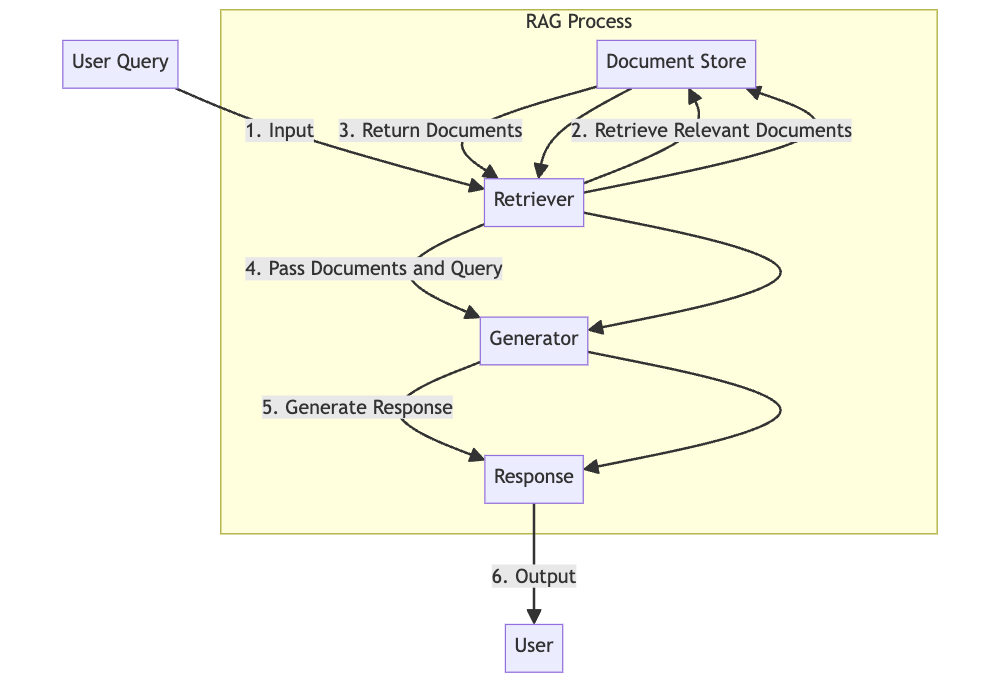

#### Lessons Learned
1. The enhancement of adding metadata to a Vector database helped me in my work life as it was part of an enrichment process I was going through. This helped solidify my foundations
2. The concept of "checking" vector similarity by subtracting man from King and having a similarity to Queen helped me understand the concept of a 'vector' and how it relates to the mathematical or physics representation of a vector.
3. For most use cases, RAG seems to suffice as searching over a select bit of information for a specific use case is less effort than fine-tuning but can yeild surprisingly powerful Results.

#### Lessons NOT Learned
1. I still conceptually don't undertand the "assistant" role and how it differs from "system", is it just for saved session information about previous messages in a chat for example? I don't see the value in this role.
2. I am still confused as to how the Vector DB algorithmically defines the vector and finds similar vectors. I get the idea of cosine similarity but bue actual 'retrieval' part is still black box to me. 
3. I still need to understand more about chunking, If it is just splitting up the text into more bitesize peices for LLM to digest, that makes sense, but somehow I feel like creating a vector score for a whole text file seems more valuable? Perhaps if your response just needs to be a snippet of information from a file?